In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import datetime
from openpyxl import load_workbook

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor


from parser.inflation import download_inflation, get_inflation_df
from data_transform.transform_df import transform_df_to_format
from parser.loans_volume_msp import get_loans_volume_msp_df
from parser.dollar import get_dollar_df
from parser.broad_money_supply import get_broad_money_supply
from parser.bal import get_bal_df
from parser.cpi import get_cpi_df
from parser.bal_increase import get_bal_increase_df
from parser.gdp import get_gdp_on_2021_prices_dataframe
from parser.gdp import get_gdp_dataframe_wout_seasons

import dateparser
import matplotlib.dates as mdates

# 1. Выгрузка необходимых данных

## Получим данные по объему кредитов

In [143]:
df = transform_df_to_format(get_loans_volume_msp_df(2019, 2024, spikes_remove = True))
df

C:\Users\Дарья\Documents\pydatan\проект\hub-act-frcst\data_transform\spices_remove.py:22: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df[column_name][outliers] = None
C:\Users\Дарья\Documents\pydatan\проект\hub-act-frcst\data_transform\spi

,msp_loans_volume,month_n,year,Отчетный период
0,4.028862e+05,1,2019,Январь 2019 г.
1,4.208281e+05,2,2019,Февраль 2019 г.
2,7.157937e+05,3,2019,Март 2019 г.
3,6.368802e+05,4,2019,Апрель 2019 г.
4,5.239981e+05,5,2019,Май 2019 г.
...,...,...,...,...
59,1.437707e+06,12,2023,Декабрь 2023 г.
60,1.221420e+06,1,2024,Январь 2024 г.
61,1.155451e+06,2,2024,Февраль 2024 г.
62,1.636295e+06,3,2024,Март 2024 г.


In [5]:
list_of_df = [] # список для хранения датафреймов с интересущими нас параметрами

## Выгружаем данные по инфляции и ключевой ставке

In [6]:
start_date = datetime.datetime.strptime("01.01.2019", "%d.%m.%Y")
end_date = datetime.datetime.strptime("01.05.2024", "%d.%m.%Y")
download_inflation(start_date, end_date)
df_inflation = transform_df_to_format(get_inflation_df(start_date, end_date, spikes_remove=False))
df_inflation = df_inflation.reset_index(drop=True)
list_of_df.append(df_inflation)
df_inflation

C:\Users\Дарья\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\styles\stylesheet.py:241: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,"Ключевая ставка, % годовых","Инфляция, % г/г",month_n,year,Отчетный период
0,7.75,5.00,1,2019,Январь 2019 г.
1,7.75,5.20,2,2019,Февраль 2019 г.
2,7.75,5.30,3,2019,Март 2019 г.
3,7.75,5.20,4,2019,Апрель 2019 г.
4,7.75,5.10,5,2019,Май 2019 г.
...,...,...,...,...,...
59,16.00,7.42,12,2023,Декабрь 2023 г.
60,16.00,7.44,1,2024,Январь 2024 г.
61,16.00,7.69,2,2024,Февраль 2024 г.
62,16.00,7.72,3,2024,Март 2024 г.


## Выгружаем данные о курсе доллара

In [7]:
df_dollar = transform_df_to_format(get_dollar_df(start_date, end_date))
list_of_df.append(df_dollar)
df_dollar

C:\Users\Дарья\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\styles\stylesheet.py:241: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,curs,month_n,year,Отчетный период
0,66.512544,1,2019,Январь 2019 г.
1,65.810525,2,2019,Февраль 2019 г.
2,65.092257,3,2019,Март 2019 г.
3,64.603105,4,2019,Апрель 2019 г.
4,64.818706,5,2019,Май 2019 г.
...,...,...,...,...
59,90.817186,12,2023,Декабрь 2023 г.
60,88.680288,1,2024,Январь 2024 г.
61,91.518255,2,2024,Февраль 2024 г.
62,91.731633,3,2024,Март 2024 г.


## Выгружаем данные о широкой денежной массе 

In [8]:
broad_money_supply = transform_df_to_format(get_broad_money_supply(2019, 2024))
list_of_df.append(broad_money_supply)
broad_money_supply

,broad_money,month_n,year,Отчетный период
0,59779.4,1,2019,Январь 2019 г.
1,60469.3,2,2019,Февраль 2019 г.
2,60146.8,3,2019,Март 2019 г.
3,60481.3,4,2019,Апрель 2019 г.
4,60959.4,5,2019,Май 2019 г.
...,...,...,...,...
59,112483.1,12,2023,Декабрь 2023 г.
60,111777.1,1,2024,Январь 2024 г.
61,113844.5,2,2024,Февраль 2024 г.
62,114105.6,3,2024,Март 2024 г.


## Выгружаем данные о ВВП

In [9]:
gdp_on_2021_prices_df = get_gdp_on_2021_prices_dataframe()
gdp_on_2021_prices_df = gdp_on_2021_prices_df[gdp_on_2021_prices_df['date'] >= start_date]
gdp_on_2021_prices_df = gdp_on_2021_prices_df[gdp_on_2021_prices_df['date'] < end_date]
gdp_on_2021_prices_df = gdp_on_2021_prices_df.drop('date', axis = 1)
gdp_on_2021_prices_df = gdp_on_2021_prices_df.reset_index(drop=True)
gdp_on_2021_prices_df = gdp_on_2021_prices_df.rename(columns={'gdp': 'gdp_on_2021_prices'})
gdp_on_2021_prices_df

C:\Users\Дарья\Documents\pydatan\проект\hub-act-frcst\parser\gdp.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_df = pd.concat([new_df, pd.DataFrame(


,gdp_on_2021_prices
0,29280.396315
1,29280.396315
2,29280.396315
3,31805.782772
4,31805.782772
...,...
56,35797.406698
57,39268.666618
58,39268.666618
59,39268.666618


In [10]:
gdp_wout_seasons_df = get_gdp_dataframe_wout_seasons()
gdp_wout_seasons_df = gdp_wout_seasons_df[gdp_wout_seasons_df['date'] >= start_date]
gdp_wout_seasons_df = gdp_wout_seasons_df[gdp_wout_seasons_df['date'] < end_date]
gdp_wout_seasons_df = gdp_wout_seasons_df.drop('date', axis = 1)
gdp_wout_seasons_df = gdp_wout_seasons_df.reset_index(drop=True)
gdp_wout_seasons_df = gdp_wout_seasons_df.rename(columns={'gdp': 'gdp_wout_seasons'})
gdp_wout_seasons_df

C:\Users\Дарья\Documents\pydatan\проект\hub-act-frcst\parser\gdp.py:104: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_df = pd.concat([new_df, pd.DataFrame(


,gdp_wout_seasons
0,32614.810098
1,32614.810098
2,32614.810098
3,32725.823537
4,32725.823537
...,...
56,34951.030276
57,35225.308081
58,35225.308081
59,35225.308081


## Выгрузка данных о темпе прироста потребительских цен

In [11]:
bal_increase_df = get_bal_increase_df(spikes_remove=False) # до мая 2024 года, тут тоже не работает True
bal_increase_df = bal_increase_df[bal_increase_df['date'] >= start_date]
bal_increase_df = bal_increase_df[bal_increase_df['date'] < end_date]
bal_increase_df = bal_increase_df.drop('date', axis = 1)
bal_increase_df = bal_increase_df.reset_index(drop=True)
bal_increase_df

,bal_increase
0,0.738837
1,0.326346
2,0.291960
3,0.261887
4,0.361780
...,...
59,0.539416
60,0.509108
61,0.509485
62,0.369283


# Соединяем датафреймы для получения итогового и смотрим корреляцию

In [12]:
df_total = df
for i in list_of_df:
    df_total = pd.merge(df_total, i,  on=['Отчетный период', 'month_n', 'year'], how='inner')
df_total = pd.concat([df_total, bal_increase_df], axis = 1)
df_total = pd.concat([df_total, gdp_wout_seasons_df], axis = 1)
df_total = pd.concat([df_total, gdp_on_2021_prices_df], axis = 1)
df_total['gdp_wout_seasons'] = df_total['gdp_wout_seasons'].fillna(method='ffill')
df_total['gdp_on_2021_prices'] = df_total['gdp_on_2021_prices'].fillna(method='ffill')
df_total

C:\Users\Дарья\AppData\Local\Temp\ipykernel_14632\3351855043.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_total['gdp_wout_seasons'] = df_total['gdp_wout_seasons'].fillna(method='ffill')
C:\Users\Дарья\AppData\Local\Temp\ipykernel_14632\3351855043.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_total['gdp_on_2021_prices'] = df_total['gdp_on_2021_prices'].fillna(method='ffill')


,msp_loans_volume,month_n,year,Отчетный период,"Ключевая ставка, % годовых","Инфляция, % г/г",curs,broad_money,bal_increase,gdp_wout_seasons,gdp_on_2021_prices
0,4.028862e+05,1,2019,Январь 2019 г.,7.75,5.00,66.512544,59779.4,0.738837,32614.810098,29280.396315
1,4.208281e+05,2,2019,Февраль 2019 г.,7.75,5.20,65.810525,60469.3,0.326346,32614.810098,29280.396315
2,7.157937e+05,3,2019,Март 2019 г.,7.75,5.30,65.092257,60146.8,0.291960,32614.810098,29280.396315
3,6.368802e+05,4,2019,Апрель 2019 г.,7.75,5.20,64.603105,60481.3,0.261887,32725.823537,31805.782772
4,5.239981e+05,5,2019,Май 2019 г.,7.75,5.10,64.818706,60959.4,0.361780,32725.823537,31805.782772
...,...,...,...,...,...,...,...,...,...,...,...
59,1.437707e+06,12,2023,Декабрь 2023 г.,16.00,7.42,90.817186,112483.1,0.539416,35225.308081,39268.666618
60,1.221420e+06,1,2024,Январь 2024 г.,16.00,7.44,88.680288,111777.1,0.509108,35575.609534,32256.951209
61,1.155451e+06,2,2024,Февраль 2024 г.,16.00,7.69,91.518255,113844.5,0.509485,35575.609534,32256.951209
62,1.636295e+06,3,2024,Март 2024 г.,16.00,7.72,91.731633,114105.6,0.369283,35575.609534,32256.951209


In [13]:
df_total_for_corr = df_total.drop('Отчетный период', axis = 1) # убираем отчетный период, так как данный тип данных мешает рассчету корреляции
df_total_for_corr.corr()

,msp_loans_volume,month_n,year,"Ключевая ставка, % годовых","Инфляция, % г/г",curs,broad_money,bal_increase,gdp_wout_seasons,gdp_on_2021_prices
msp_loans_volume,1.000000,0.317559,0.715643,0.506419,0.170371,0.587440,0.806801,0.087231,0.733259,0.498325
month_n,0.317559,1.000000,-0.129944,-0.137714,0.023423,-0.071525,0.007091,-0.124930,0.038295,0.885653
year,0.715643,-0.129944,1.000000,0.599115,0.425530,0.613057,0.967019,0.149219,0.758250,0.166922
"Ключевая ставка, % годовых",0.506419,-0.137714,0.599115,1.000000,0.456871,0.606438,0.632359,0.444930,0.627180,0.116757
"Инфляция, % г/г",0.170371,0.023423,0.425530,0.456871,1.000000,-0.075242,0.308827,0.279505,0.218996,0.097258
curs,0.587440,-0.071525,0.613057,0.606438,-0.075242,1.000000,0.702048,0.518350,0.639771,0.168420
broad_money,0.806801,0.007091,0.967019,0.632359,0.308827,0.702048,1.000000,0.125676,0.805886,0.299531
bal_increase,0.087231,-0.124930,0.149219,0.444930,0.279505,0.518350,0.125676,1.000000,0.202543,-0.052072
gdp_wout_seasons,0.733259,0.038295,0.758250,0.627180,0.218996,0.639771,0.805886,0.202543,1.000000,0.429900
gdp_on_2021_prices,0.498325,0.885653,0.166922,0.116757,0.097258,0.168420,0.299531,-0.052072,0.429900,1.000000


Оставляем параметры, которые показали хорошую корреляцию с объемом кредитов

In [14]:
df_total = df_total[['Отчетный период', 'msp_loans_volume', 'Ключевая ставка, % годовых', 'month_n', 'year','curs', 'broad_money', 'gdp_wout_seasons', 'gdp_on_2021_prices']]
df_total.head()

,Отчетный период,msp_loans_volume,"Ключевая ставка, % годовых",month_n,year,curs,broad_money,gdp_wout_seasons,gdp_on_2021_prices
0,Январь 2019 г.,402886.167196,7.75,1,2019,66.512544,59779.4,32614.810098,29280.396315
1,Февраль 2019 г.,420828.091005,7.75,2,2019,65.810525,60469.3,32614.810098,29280.396315
2,Март 2019 г.,715793.741799,7.75,3,2019,65.092257,60146.8,32614.810098,29280.396315
3,Апрель 2019 г.,636880.167196,7.75,4,2019,64.603105,60481.3,32725.823537,31805.782772
4,Май 2019 г.,523998.091005,7.75,5,2019,64.818706,60959.4,32725.823537,31805.782772


# Подготовка данных и обучение модели

## Подготовка данных 

In [15]:
# Извлекаем год из столбца "Отчетный период"
df_total['data'] = df['Отчетный период'].str.extract(r'(\d{4})').astype(int)

# Формируем новый столбец "Дата" в формате YYYY-MM
df_total['data'] = df_total['data'].astype(str) + '-' + df_total['month_n'].astype(str)
df_total['data'] = pd.to_datetime(df_total['data'])

# Удаляем временные столбцы
df_total = df_total.drop('Отчетный период', axis=1)
df_total

C:\Users\Дарья\AppData\Local\Temp\ipykernel_14632\1437758174.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total['data'] = df['Отчетный период'].str.extract(r'(\d{4})').astype(int)
C:\Users\Дарья\AppData\Local\Temp\ipykernel_14632\1437758174.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total['data'] = df_total['data'].astype(str) + '-' + df_total['month_n'].astype(str)
C:\Users\Дарья\AppData\Local\Temp\ipykernel_14632\1437758174.py:6: SettingWithCopyWarning: 
A value is trying to be set o

,msp_loans_volume,"Ключевая ставка, % годовых",month_n,year,curs,broad_money,gdp_wout_seasons,gdp_on_2021_prices,data
0,4.028862e+05,7.75,1,2019,66.512544,59779.4,32614.810098,29280.396315,2019-01-01
1,4.208281e+05,7.75,2,2019,65.810525,60469.3,32614.810098,29280.396315,2019-02-01
2,7.157937e+05,7.75,3,2019,65.092257,60146.8,32614.810098,29280.396315,2019-03-01
3,6.368802e+05,7.75,4,2019,64.603105,60481.3,32725.823537,31805.782772,2019-04-01
4,5.239981e+05,7.75,5,2019,64.818706,60959.4,32725.823537,31805.782772,2019-05-01
...,...,...,...,...,...,...,...,...,...
59,1.437707e+06,16.00,12,2023,90.817186,112483.1,35225.308081,39268.666618,2023-12-01
60,1.221420e+06,16.00,1,2024,88.680288,111777.1,35575.609534,32256.951209,2024-01-01
61,1.155451e+06,16.00,2,2024,91.518255,113844.5,35575.609534,32256.951209,2024-02-01
62,1.636295e+06,16.00,3,2024,91.731633,114105.6,35575.609534,32256.951209,2024-03-01


## Разделение данных на тестовые, тренировочные и валидационные

In [149]:
split_data = '2023-06'
trn_val = df_total[df_total['data']<split_data]
trn, val = train_test_split(trn_val, test_size=0.2, random_state=47)
test = df_total[df_total['data']>=split_data]

# тренировочные данные
Xtrn = trn.drop(['data', 'msp_loans_volume'], axis = 1)
Ytrn = trn['msp_loans_volume']

# данные для вывода (будет позднее) фактических значений 
Y_trn_val = trn_val['msp_loans_volume']

# тренировочные данные
Xtest = test.drop(['data', 'msp_loans_volume'], axis = 1)
Ytest = test['msp_loans_volume']

# валидационные данные 
Xval = val.drop(['data', 'msp_loans_volume'], axis = 1)
Yval = val['msp_loans_volume']

print(trn.shape, val.shape, test.shape)

(42, 9) (11, 9) (11, 9)


## Создание и обучение модели

In [150]:
regressor = CatBoostRegressor(iterations=1000, depth=2, learning_rate=0.01)
regressor.fit(Xtrn, Ytrn, verbose=False)

# Предсказание и оценка
predictions = regressor.predict(Xtest)
print(predictions)

[1180611.71020606 1105711.75639379 1102969.73390697 1115155.28338711
 1113105.93395135 1113990.3759808  1309386.32294249  898336.58524595
  919430.69572984 1162687.91009468 1143693.14026031]


In [151]:
Ytest # можно сравнить с тем, что получилось выше

53    1.487425e+06
54    1.248651e+06
55    1.475003e+06
56    1.687433e+06
57    1.684164e+06
58    1.318051e+06
59    1.437707e+06
60    1.221420e+06
61    1.155451e+06
62    1.636295e+06
63    1.541567e+06
Name: msp_loans_volume, dtype: float64

## Рассчет средней абсолютной процентная ошибки (MAPE) 

Рассчет средней абсолютной процентная ошибки (MAPE) - средняя разница между прогнозируемым значением и фактическим значением

In [152]:
def mape(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    actual_safe = np.where(actual == 0, 1e-10, actual)
    return np.mean(np.abs((actual - pred) / actual_safe))

mape(Ytest.values, predictions)

0.2283253616012391

## Визуальный анализ

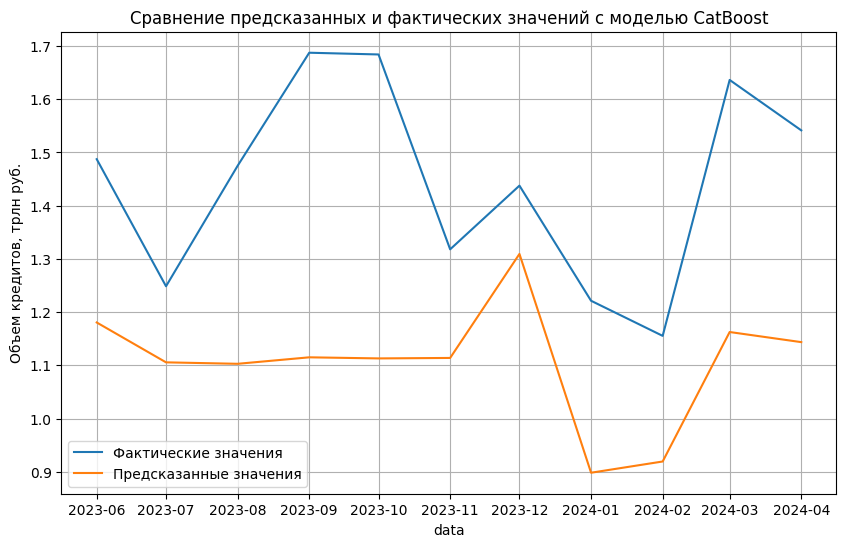

In [153]:
# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(test['data'], Ytest.values/ 1e6, label='Фактические значения')
plt.plot(test['data'], predictions/ 1e6, label='Предсказанные значения')
plt.xlabel('data')
plt.ylabel('Объем кредитов, трлн руб.')
plt.title('Сравнение предсказанных и фактических значений с моделью CatBoost')
plt.legend()
plt.grid(True)
plt.show()

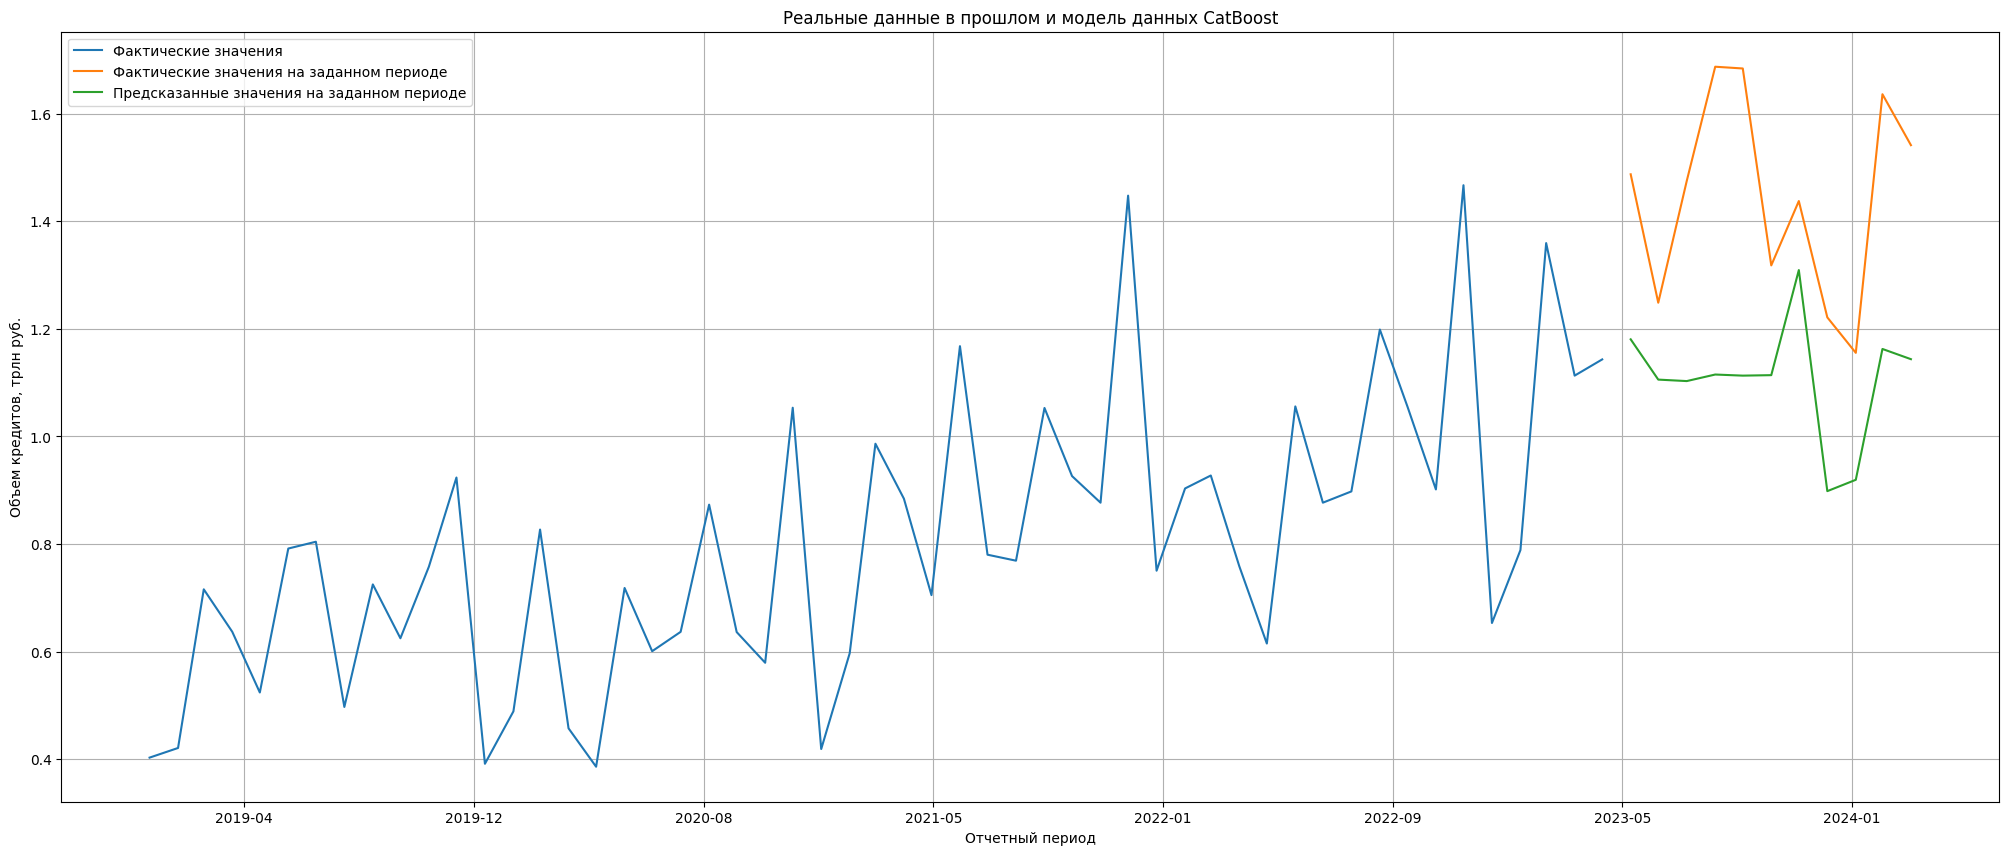

In [154]:
# Построение графика
plt.figure(figsize=(25, 10))
plt.plot(mdates.date2num(trn_val['data']), Y_trn_val.values/ 1e6, label='Фактические значения')
plt.plot(mdates.date2num(test['data']), Ytest.values/ 1e6, label='Фактические значения на заданном периоде')
plt.plot(mdates.date2num(test['data']), predictions/ 1e6, label='Предсказанные значения на заданном периоде')
plt.xlabel('Отчетный период')
plt.ylabel('Объем кредитов, трлн руб.')
plt.title('Реальные данные в прошлом и модель данных CatBoost')
plt.legend()
plt.grid(True)
# Настройка отображения дат на оси X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # формат даты

plt.show()

# Оптимизация гиперпараметров

In [155]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

mape_scorer = make_scorer(mape, greater_is_better=False)

# Создание объекта GridSearchCV
grid_search = GridSearchCV(estimator=CatBoostRegressor(verbose=False), 
                           param_grid=param_grid, 
                           cv=3, 
                           scoring=mape_scorer) 

# Запуск поиска по сетке гиперпараметров НА ТРЕНИРОВОЧНЫХ ДАННЫХ
grid_search.fit(Xtrn, Ytrn)

# Вывод лучших гиперпараметров
print("Лучшие параметры:", grid_search.best_params_)

# Создание модели с лучшими гиперпараметрами
best_regressor = grid_search.best_estimator_

# Предсказание и оценка на ВАЛИДАЦИОННЫХ данных
predictions_val = best_regressor.predict(Xval) 
predictions_val

Лучшие параметры: {'depth': 2, 'iterations': 1000, 'learning_rate': 0.05}


array([ 971889.62589831,  949284.97749583,  847521.9925107 ,
       1202397.06142413,  939336.76521221,  938491.58480048,
        837818.94593428,  616212.21682895,  418081.13689641,
        636323.48604358,  650441.18132798])

In [156]:
mape(Yval.values, predictions_val)

0.21026365558408588

In [157]:
predictions_opt = best_regressor.predict(Xtest)
mape(Ytest.values, predictions_opt)

0.25317944133465403

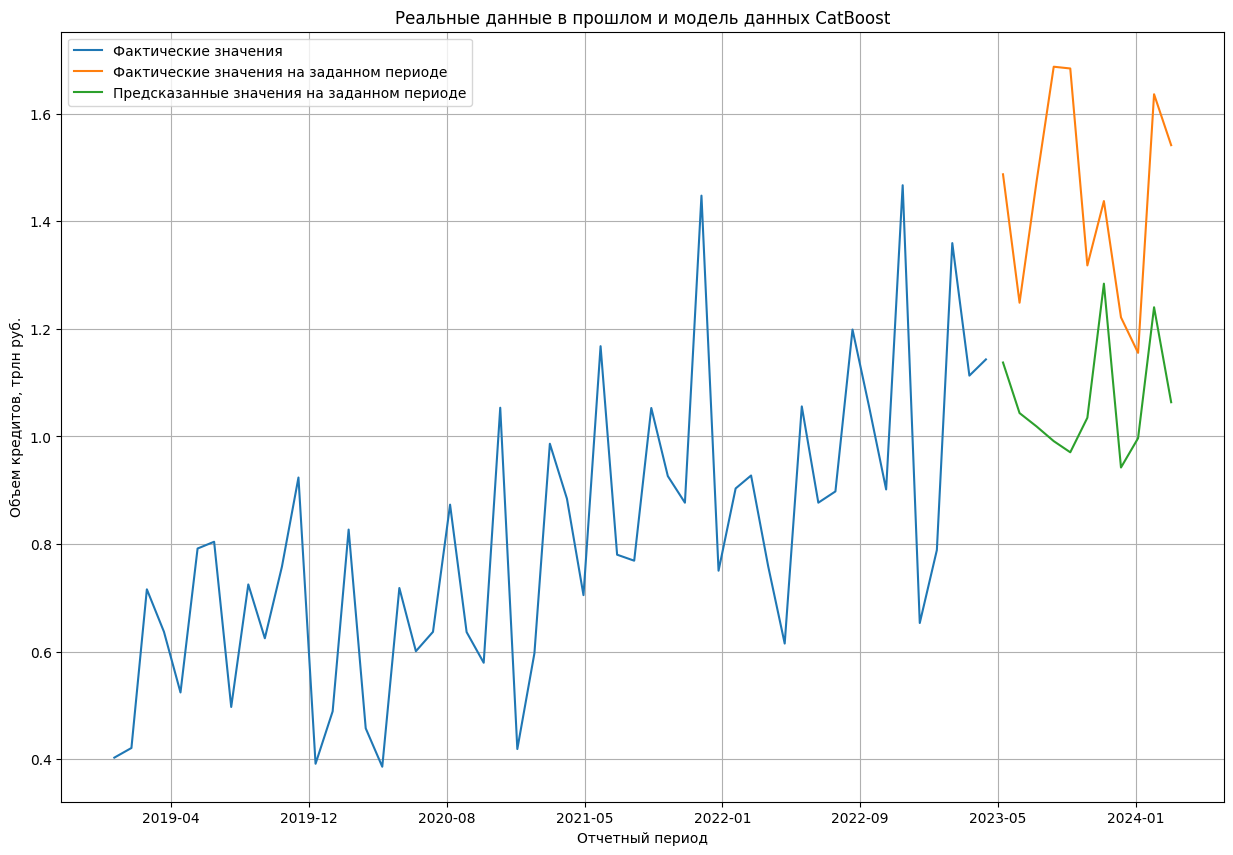

In [158]:
# Построение графика
plt.figure(figsize=(15, 10))
plt.plot(mdates.date2num(trn_val['data']), Y_trn_val.values/ 1e6, label='Фактические значения')
plt.plot(mdates.date2num(test['data']), Ytest.values/ 1e6, label='Фактические значения на заданном периоде')
plt.plot(mdates.date2num(test['data']), predictions_opt/ 1e6, label='Предсказанные значения на заданном периоде')
plt.xlabel('Отчетный период')
plt.ylabel('Объем кредитов, трлн руб.')
plt.title('Реальные данные в прошлом и модель данных CatBoost')
plt.legend()
plt.grid(True)
# Настройка отображения дат на оси X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # формат даты

plt.show()

# Отбор наилучших признаков

## Алгоритм для отбора и обучения модели

In [159]:
from sklearn.feature_selection import SequentialFeatureSelector

# Создание объекта SequentialFeatureSelector
selector = SequentialFeatureSelector(best_regressor,  # Используем модель с лучшими гиперпараметрами
                                   n_features_to_select='auto',
                                   direction='forward',
                                   scoring=mape_scorer,  # Используем метрику
                                   cv=3) 

# Обучение селектора на ТРЕНИРОВОЧНЫХ данных
selector.fit(Xtrn, Ytrn)

# Получение маски выбранных признаков
selected_features_mask = selector.get_support()

# Вывод названий выбранных признаков
selected_features = Xtrn.columns[selected_features_mask]
print("Выбранные признаки:", selected_features)

# Преобразование данных с использованием выбранных признаков
Xtrn_selected = selector.transform(Xtrn)
Xval_selected = selector.transform(Xval)
Xtest_selected = selector.transform(Xtest) # Преобразование тестовых данных

# Обучение модели с лучшими гиперпараметрами и выбранными признаками на ТРЕНИРОВОЧНЫХ данных
best_regressor.fit(Xtrn_selected, Ytrn, verbose=False)

# Предсказание на ВАЛИДАЦИОННЫХ данных 
predictions_val = best_regressor.predict(Xval_selected)

Выбранные признаки: Index(['month_n', 'year', 'broad_money'], dtype='object')


In [161]:
mape(Yval.values, predictions_val)

0.20504301286352228

In [162]:
predictions_opt_total = best_regressor.predict(Xtest_selected)
mape(Ytest.values, predictions_opt_total)

0.1924057655482075

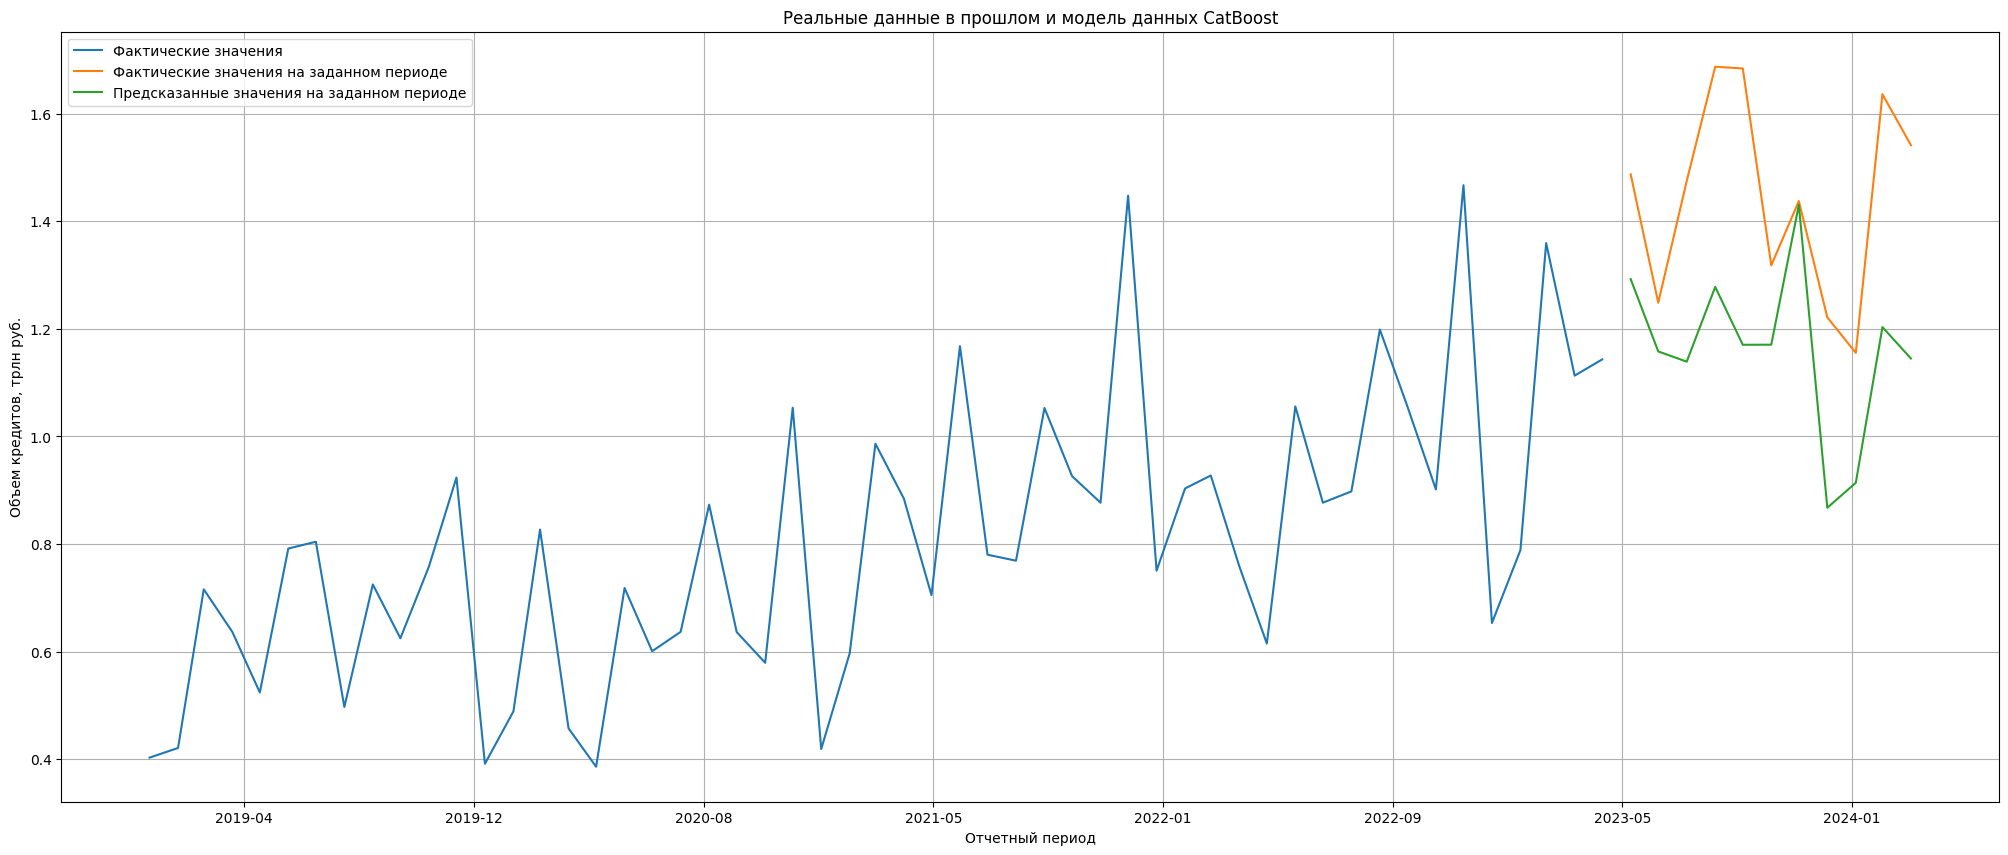

In [163]:
# Построение графика
plt.figure(figsize=(25, 10))
plt.plot(mdates.date2num(trn_val['data']), Y_trn_val.values/ 1e6, label='Фактические значения')
plt.plot(mdates.date2num(test['data']), Ytest.values/ 1e6, label='Фактические значения на заданном периоде')
plt.plot(mdates.date2num(test['data']), predictions_opt_total/ 1e6, label='Предсказанные значения на заданном периоде')
plt.xlabel('Отчетный период')
plt.ylabel('Объем кредитов, трлн руб.')
plt.title('Реальные данные в прошлом и модель данных CatBoost')
plt.legend()
plt.grid(True)
# Настройка отображения дат на оси X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # формат даты

plt.show()

Выполним предсказание до конца 2025 года